# Synthetic Data Comparison

In this notebook, different ways to compare the quality of augmented time series are explored.

## Imports and static variables

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from copy import deepcopy as dc

# own classes
from utilities import load_sequential_time_series, reconstruct_sequential_data, load_complete_time_series, slice_years, train_test_split, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model, LSTMClassification
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor

In [2]:
DATA_FOLDER = Path("./data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"

In [3]:
MODEL = 'lstm'
MODE = 'classification'
FEATURES = ['Trend', 'Log Close', 'Volume', 'Daily Returns Percent']
CLASSES = ['down', 'up']

LEARNING_RATE = 0.0001 if MODEL == 'lstm' else 0.0001
FIRST_SPLIT = 0.9
SECOND_SPLIT = 0.5 

SEQ_LEN = 7
BATCH_SIZE = 8
HIDDEN_SIZE = 8
NUM_LAYERS = 1
OUTPUT_LOGITS = True

NUM_EPOCHS = 1000

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading data

In [5]:
aapl = load_complete_time_series(REAL_DATA_FOLDER / "AAPL_complete.csv")

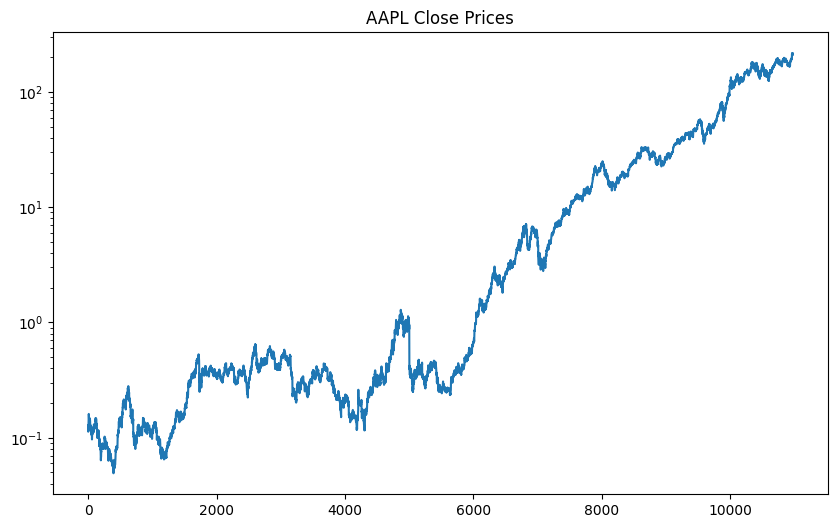

In [6]:
# plot log of close prices
plt.figure(figsize=(10, 6))
plt.plot(aapl['Close'])
plt.yscale('log')
plt.title('AAPL Close Prices')
plt.show()

In [7]:
# get normal difference
# aapl['Daily Returns'] = aapl['Close'].diff()

# get percaentage difference
aapl['Daily Returns Percent'] = aapl['Close'].pct_change()

In [8]:
# get log values
aapl['Log Close'] = np.log(aapl['Close'])

In [9]:
# set trend to 1 if daily return > 1, else -1
aapl['Trend'] = aapl['Daily Returns Percent'].apply(lambda x: 1 if x > 0 else 0)

In [10]:
aapl = aapl.dropna()
aapl = aapl[FEATURES]

In [11]:
aapl.head(25)

,Trend,Log Close,Volume,Daily Returns Percent
1,0,-2.106591,175884800,-0.052171
2,0,-2.182822,105728000,-0.073398
3,1,-2.158372,86441600,0.024751
4,1,-2.129792,73449600,0.028992
5,1,-2.070553,48630400,0.061029
6,1,-2.023031,37363200,0.048669
7,1,-1.981698,46950400,0.042199
8,1,-1.930408,48003200,0.052628
9,1,-1.842114,55574400,0.092309
10,1,-1.828129,93161600,0.014084


In [12]:
aapl_np = aapl.to_numpy()

In [13]:
aapl_train, aapl_test = train_test_split(aapl_np, FIRST_SPLIT)
aapl_test, aapl_val = train_test_split(aapl_test, SECOND_SPLIT)

In [14]:
aapl_test_dummy = split_data_into_sequences(aapl_test, SEQ_LEN)

Shape of the data after splitting into sequences: (543, 7, 4)


In [15]:
scaler = Scaler(aapl_train)

In [16]:
aapl_train_scaled = scaler.scale_data(aapl_train)
aapl_test_scaled = scaler.scale_data(aapl_test)
aapl_val_scaled = scaler.scale_data(aapl_val)

In [17]:
aapl_train_seq_scaled = split_data_into_sequences(aapl_train_scaled, SEQ_LEN)
aapl_test_seq_scaled = split_data_into_sequences(aapl_test_scaled, SEQ_LEN)
aapl_val_seq_scaled = split_data_into_sequences(aapl_val_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (9873, 7, 4)
Shape of the data after splitting into sequences: (543, 7, 4)
Shape of the data after splitting into sequences: (543, 7, 4)


In [18]:
aapl_train_seq_scaled[0]

array([[0.        , 0.12229161, 0.02369891, 0.09644285],
       [0.        , 0.11201516, 0.01424591, 0.04655351],
       [1.        , 0.11531112, 0.01164724, 0.27722803],
       [1.        , 0.11916391, 0.00989668, 0.28719656],
       [1.        , 0.12714972, 0.00655251, 0.36249006],
       [1.        , 0.13355602, 0.00503436, 0.33344264],
       [1.        , 0.13912799, 0.00632615, 0.31823562]])

In [19]:
X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(aapl_train_seq_scaled, aapl_test_seq_scaled, aapl_val_seq_scaled)

In [20]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
criterion = nn.MSELoss()
criterion_absolute = nn.L1Loss()
criterion_binary_logits = nn.BCEWithLogitsLoss()
criterion_binary = nn.BCELoss()

In [23]:
val_losses = []
val_accs = []
train_losses = []
train_accs = []
validation_loss_accumulation_callback = ValidationLossAccumulationCallback(val_losses)

In [24]:
X_train.reshape((X_train.shape[0], -1)).shape, y_train.shape

(torch.Size([9873, 18]), torch.Size([9873, 1]))

In [25]:
if MODEL == 'lstm':

    model = LSTMClassification(
        device=device,
        batch_size = BATCH_SIZE,
        input_size=X_train.shape[2], # number of features
        hidden_size=HIDDEN_SIZE,
        num_stacked_layers=NUM_LAYERS,
        output_logits=OUTPUT_LOGITS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, train_accs, val_losses, val_accs, model = train_model(model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion_binary_logits if OUTPUT_LOGITS else criterion_binary,
                        optimizer=optimizer,
                        device=device)
        
elif MODEL == 'xgb':

    model = XGBClassifier(
        objective='binary:logistic',      
        max_depth=10,       
        learning_rate=0.00005,
        n_estimators=1000,
        verbosity=2,
        early_stopping_rounds=10,
        callbacks=[validation_loss_accumulation_callback], 
        reg_alpha=0.01,
        reg_lambda=0.01
    )
    
    model.fit(
        X_train.reshape((X_train.shape[0], -1)), 
        y_train,
        eval_set=[(X_val.reshape((X_val.shape[0], -1)), y_val)]
    )

Epoch: 1
Training Loss: 0.007105785608291626
Training Loss: 0.6895444732904434
Training Loss: 0.689852010011673
Training Loss: 0.6916859579086304
Training Loss: 0.6909025079011917
Training Loss: 0.6885823297500611
Training Loss: 0.6945057827234268
Training Loss: 0.6899576169252396
Training Loss: 0.7001829344034195
Training Loss: 0.6963855105638505
Training Loss: 0.6976947706937789
Training Loss: 0.693666165471077
Training Loss: 0.6947020572423935
Batch size did not match
Batch size did not match
Batch size did not match
Validation Loss: 0.6938423225108314
Validation Accuracy: 47.6890756302521
**************************************************
Epoch: 2
Batch size did not match
Training Loss: 0.007012259364128113
Training Loss: 0.6907330989837647
Training Loss: 0.6907683742046357
Training Loss: 0.6918603020906449
Training Loss: 0.6914453494548798
Training Loss: 0.6899315404891968
Training Loss: 0.6933315646648407
Training Loss: 0.6908011490106583
Training Loss: 0.6968088591098786
Trainin

Text(0.5, 1.0, 'Validation Accuracy')

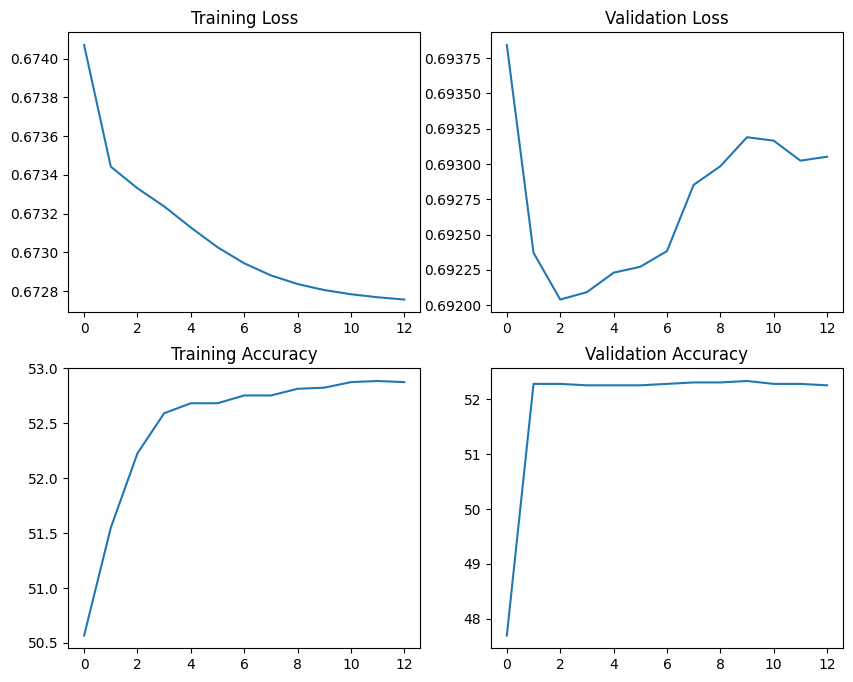

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Diagramm 1 (oben links)
axs[0, 0].plot(train_losses, label="BCELoss")
axs[0, 0].set_title('Training Loss')

axs[0, 1].plot(val_losses, label="BCELoss")
axs[0, 1].set_title('Validation Loss')

axs[1, 0].plot(train_accs, label="Accuracy")
axs[1, 0].set_title('Training Accuracy')

axs[1, 1].plot(val_accs, label="Accuracy")
axs[1, 1].set_title('Validation Accuracy')

## Evaluation

In [27]:
if MODEL == 'lstm':

    with torch.inference_mode(): 
        test_logits = model(X_test.to(device)) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes
        train_logits = model(X_train.to(device))
        train_probs = torch.sigmoid(train_logits)
        train_preds = torch.round(train_probs)

elif MODEL == 'xgb':
        
    test_preds = model.predict(X_test.reshape((X_test.shape[0], -1)))
    train_preds = model.predict(X_train.reshape((X_train.shape[0], -1)))

Batch size did not match
Batch size did not match


In [28]:
if MODE == 'regression':
    test_logits = scaler.inverse_scale_data(test_logits, feature_type='price')
    train_logits = scaler.inverse_scale_data(train_logits, feature_type='price')
    y_test = scaler.inverse_scale_data(y_test.cpu().numpy(), feature_type='price')
    y_train = scaler.inverse_scale_data(y_train.cpu().numpy(), feature_type='price')

elif MODE == 'classification':
    accuracy(y_true=y_test.flatten(), y_pred=torch.tensor(test_preds))

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_36970/2978573850.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accuracy(y_true=y_test.flatten(), y_pred=torch.tensor(test_preds))


In [29]:
# mean absolute error of only zeros
loss = criterion_absolute(torch.zeros_like(torch.tensor(y_test)), torch.tensor(y_test)).item()
loss

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_36970/2105286845.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion_absolute(torch.zeros_like(torch.tensor(y_test)), torch.tensor(y_test)).item()


0.5248618721961975

In [30]:
test_range = (0, 50)
train_range = (0, len(y_train))

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_36970/2477743262.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion_absolute(torch.tensor(test_logits), torch.tensor(y_test)).item()


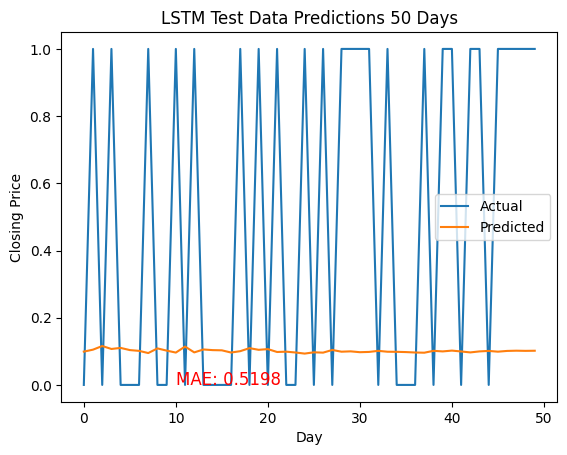

In [31]:
# mean absolute error of test data predictions
loss = criterion_absolute(torch.tensor(test_logits), torch.tensor(y_test)).item()
loss

# plot test data
plt.title(f'{"LSTM" if MODEL == "lstm" else "XGBRegressor"} Test Data Predictions {test_range[1]-test_range[0]} Days')
plt.plot(y_test[test_range[0]: test_range[1]], label="Actual")
plt.plot(np.roll(test_logits[test_range[0]: test_range[1]], 0), label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.text(10, min(y_test[test_range[0]: test_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.legend()
plt.show()

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_36970/1546953015.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion_absolute(torch.tensor(train_logits), torch.tensor(y_train)).item()


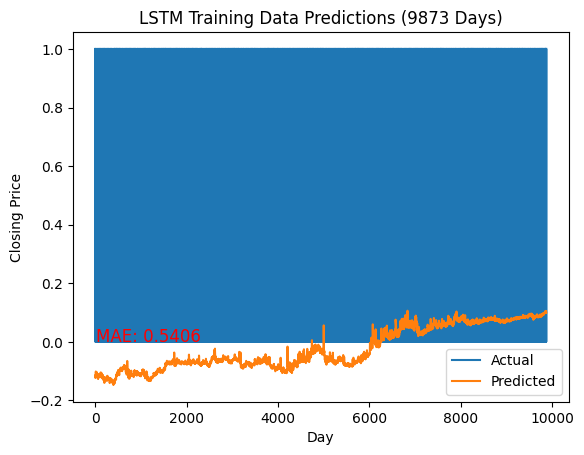

In [32]:
# mean absolute error of training data predictions
loss = criterion_absolute(torch.tensor(train_logits), torch.tensor(y_train)).item()
loss

# plot train data
plt.title(f'{"LSTM" if MODEL == "lstm" else "XGBRegressor"} Training Data Predictions ({train_range[1]-train_range[0]} Days)')
plt.plot(y_train[train_range[0]: train_range[1]], label="Actual")
plt.plot(train_logits[train_range[0]: train_range[1]], label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.legend()
plt.text(10, min(y_train[train_range[0]: train_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.show()

In [33]:
y_train[7000]

tensor([1.])

### dummy testing

In [34]:
dummy = MeanRegressor()

In [35]:
dummy_preds = dummy.make_predictions(aapl_test_dummy, returns=True if 'Daily Returns' in FEATURES else False)

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_36970/2832236691.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion_absolute(torch.tensor(dummy_preds), torch.tensor(y_test)).item()
/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([543, 1])) that is different to the input size (torch.Size([543])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


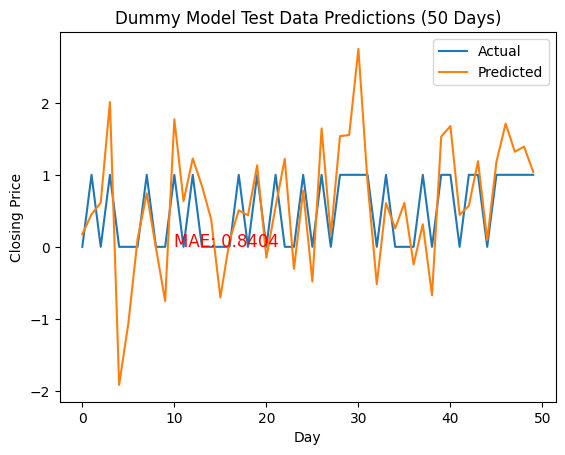

In [36]:
loss = criterion_absolute(torch.tensor(dummy_preds), torch.tensor(y_test)).item()
loss

# plot train data
plt.title(f'Dummy Model Test Data Predictions ({test_range[1]-test_range[0]} Days)')
plt.plot(y_test[test_range[0]: test_range[1]], label="Actual")
plt.plot(dummy_preds[test_range[0]: test_range[1]], label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.legend()
plt.text(10, min(y_test[test_range[0]: test_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.show()

## MAE and MSE Loss experiments

In [37]:
# real = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# A = np.array([1, 2, 3, 4, 5, 6, 8, 9, 10, 12])
# B = np.array([1, 2.1, 3.1, 4.1, 5.1, 6, 7, 8, 9, 10])

# # scale
# scaler = MinMaxScaler(feature_range=(0, 1))
# real_scaled = scaler.fit_transform(real.reshape(-1, 1))
# A_scaled = scaler.fit_transform(A.reshape(-1, 1))
# B_scaled = scaler.fit_transform(B.reshape(-1, 1))

# loss_MSE = torch.nn.MSELoss()
# loss_MAE = torch.nn.L1Loss()

# MSE_A = loss_MSE(torch.tensor(real_scaled, dtype=torch.float32), torch.tensor(A_scaled, dtype=torch.float32))
# MAE_A = loss_MAE(torch.tensor(real, dtype=torch.float32), torch.tensor(A, dtype=torch.float32))
# MSE_B = loss_MSE(torch.tensor(real_scaled, dtype=torch.float32), torch.tensor(B_scaled, dtype=torch.float32))
# MAE_B = loss_MAE(torch.tensor(real, dtype=torch.float32), torch.tensor(B, dtype=torch.float32))

# print(f'MSE_A: {MSE_A}\n')
# print(f'MAE_A: {MAE_A}\n')
# print(f'MSE_B: {MSE_B}\n')
# print(f'MAE_B: {MAE_B}\n')